In [4]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import LineString
import matplotlib.pyplot as plt

In [5]:
import sys
print(sys.executable) # confirm correct virtual env

C:\Users\brett\anaconda3\envs\pythonMaps\python.exe


In [2]:
europe_shape = gpd.read_file("C:\\Users\\brett\\OneDrive\\Documents\\Course_Materials\\PythonMaps\\map2_lines\\GRIP4_Region4_vector_shp")

In [7]:
europe_shape.to_parquet('europe.parquet', compression='gzip')

In [13]:
europe = gpd.read_parquet('./europe.parquet')

Now to plot the initial data in matplotlib. Create a figure and a subplot. this provides a canvas on which we can draw the map. then europe.plot will add the european roads data on the axes ax.
**This takes a minute to display**

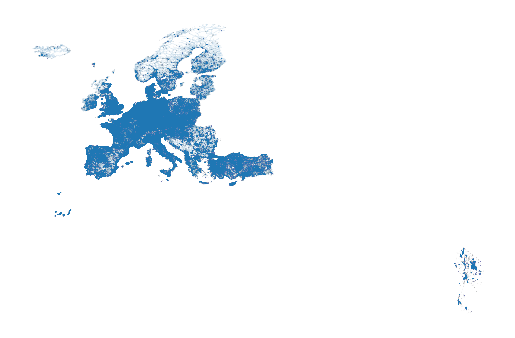

In [14]:
fig, ax = plt.subplots()
europe.plot(ax=ax, lw=0.05)
ax.axis('off')
plt.show()

Now to make it look better. dark background, use the GP_RTP column to sort colors by road type, then add an inferno colormap. specifying a column in the .plot method tells geopandas to use a colormap of colors for this column. inferno_r is the reversed colormap.
(tip: use shift + click on the image to save etc)

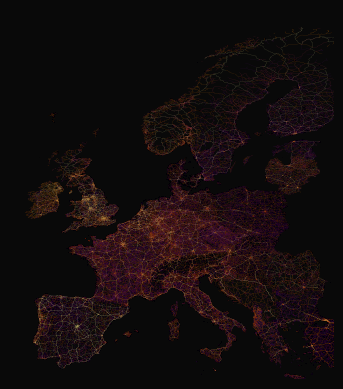

In [16]:
fig, ax = plt.subplots(facecolor='#090909')
europe.plot(ax=ax, column='GP_RTP', cmap="inferno_r", lw=0.05)
ax.axis('off')
ax.set_xlim(-12.5, 30)
ax.set_ylim(35, 73)
plt.show

Using the countries shapefile from natural earth for france, we will perform a spatial join on the two data sets to isolate roads to only france...

In [21]:
df = gpd.read_file("natural_earth/ne_10m_admin_0_countries.shp")

In [22]:
gdf = df.loc[df['ADMIN'] == 'France']

In [24]:
roads = gpd.sjoin(europe, gdf, predicate='within')

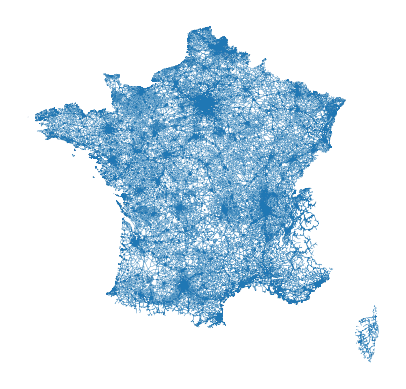

In [26]:
fig, ax = plt.subplots()
roads.plot(ax=ax, lw=0.25)
ax.axis('off')
plt.show()

Let's add features that show the road type by color and the thicknes by distance from Paris.

In [30]:
from shapely.geometry import Point, LineString
paris_gdf = gpd.GeoDataFrame({'geometry': [Point(2.3490, 48.8647)]}, crs="EPSG:4326")

Using this paris geodataframe I just created, now it's time to visualize the distance from Paris along the roadways.

In [31]:
distances = roads.distance(paris_gdf.iloc[0].geometry)
roads['distance2paris'] = distances

C:\Users\brett\AppData\Local\Temp\ipykernel_22368\2167336025.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  distances = roads.distance(paris_gdf.iloc[0].geometry)


In [32]:
print(roads)

         GP_RTP  GP_REX  GP_RAV  GP_RRG  GP_RCY  GP_RSE  GP_RSI  GP_RSY  \
862121        5       1       2      11     250       1      54    2011   
862122        5       1       2      11     250       1      54    2011   
862124        5       1       2      11     250       1      54    2011   
862125        5       1       2      11     250       1      54    2011   
862126        5       1       2      11     250       1      54    2011   
...         ...     ...     ...     ...     ...     ...     ...     ...   
8720924       1       1       2      11     250       1      54    2011   
8720925       1       1       2      11     250       1      54    2011   
8720926       1       1       2      11     250       1      54    2011   
8724370       1       1       2      11     250       1      54    2011   
8758968       1       1       2      11     250       1      54    2011   

         gp_gripreg  Shape_Leng  ... FCLASS_TR  FCLASS_ID FCLASS_PL  \
862121            4    0.000

To scale the roads, this example will use an exponential decay function. Also normalized for the smallest and largest distances. smallest will be set to the minimum lineweight for example

In [33]:
roads['distance2paris_lw'] = 1 / np.exp(roads['distance2paris'])

In [34]:
leftSpan = np.amax(roads['distance2paris_lw']) - np.amin(roads['distance2paris_lw'])
rightSpan = 0.9 - 0.05
valueScaled = (roads['distance2paris_lw'] - np.amin(roads['distance2paris_lw'])) / leftSpan
roads['distance2paris_lw'] = 0.05 + (valueScaled * rightSpan)

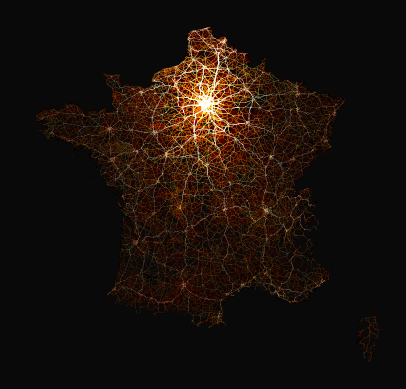

In [35]:
fig, ax = plt.subplots(facecolor='#090909')
roads.plot(ax=ax, column="GP_RTP", cmap="afmhot_r", lw=roads['distance2paris_lw'])
ax.axis('off')

plt.show()